# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**ПЛАН ВЫПОЛНЕНИЯ ЗАДАЧИ:**
1. Загрузка данных, удаление объектов с нулевым значением целевого признака;
2. Разбивка данных на обучающую, валидационную и тестовую выборки;
3. Анализ данных обучающей выборки (EDA train data). Опредение зависимостей признаков и их важности для обучения моделей;
4. Предобработка обучающих данных. Построение класса трансформера на обучающей выборке для предобработки валидационной и тестовой выборок;
5. Подготовка пайплайна обучения;
6. Обучение моделей с подбором гиперпараметров;
7. Определение лучшей модели с учетом требований заказчика;
8. Определение качества лучшей модели на тестовой выборке.

Так как в текущей задаче лучшая модель должна быть построена на табличных данных, поиск лучшей будет проводится среди моделей на основе `решающего дерева` (`'RandomForest'`, `'XGBoost'`, `'CatBoost'`, `'LightGBM'`), которые зарекомендовали себя с лучшей стороны именно на табличных данных и не чувствительны к выбросам.

## Подготовка данных

###  Загрузка и предобработка данных

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin

In [40]:
# определим константу для random_seed
RAND_ST = 777
# зададим константу определяющую текущее окружение
HUB = False
if os.environ['JUPYTERHUB_USER']:
    HUB = True
# загрузим данные в зависимости от окружения
if HUB:
    df = pd.read_csv('/datasets/autos.csv', 
                     infer_datetime_format=True, 
                     parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
else:
    df = pd.read_csv('./mydatasets/autos.csv')
# выведем информацию 
display(df.sample(10))
display(df.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
329422,2016-03-14 19:44:08,5250,wagon,2004,manual,170,3er,150000,10,petrol,bmw,no,2016-03-14,0,38536,2016-03-15 14:45:39
336089,2016-03-05 14:52:32,100,small,1989,manual,45,polo,150000,3,petrol,volkswagen,NaN,2016-03-05,0,2826,2016-03-12 03:45:13
7804,2016-03-25 19:54:30,4500,sedan,2007,manual,105,golf,150000,6,gasoline,volkswagen,no,2016-03-25,0,79211,2016-03-28 19:47:14
166811,2016-03-29 17:45:13,2500,small,2005,manual,101,ibiza,150000,2,gasoline,seat,no,2016-03-29,0,74831,2016-03-29 17:45:13
183661,2016-04-02 10:38:35,1500,sedan,1996,auto,136,e_klasse,150000,10,gasoline,mercedes_benz,no,2016-04-02,0,21423,2016-04-06 08:15:26
301384,2016-04-02 11:55:46,1000,wagon,1999,manual,184,5er,150000,12,gasoline,bmw,NaN,2016-04-02,0,26316,2016-04-04 09:15:48
208445,2016-03-27 17:57:47,2750,wagon,2000,manual,136,3er,150000,7,gasoline,bmw,no,2016-03-27,0,46459,2016-04-05 14:16:23
134125,2016-03-30 12:47:41,2200,convertible,2003,auto,61,fortwo,90000,9,petrol,smart,yes,2016-03-30,0,10719,2016-04-05 00:45:23
129888,2016-04-04 00:54:35,0,convertible,1997,manual,115,astra,150000,4,petrol,opel,NaN,2016-04-04,0,98669,2016-04-06 09:16:48
147384,2016-03-24 10:50:54,1500,small,2001,manual,58,corsa,90000,5,petrol,opel,no,2016-03-24,0,12159,2016-03-30 10:44:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

None

Объем представленных данных: 354369 наблюдений, 16 признаков.
Данные имеют следующие признаки:

- `'DateCrawled'` — дата скачивания анкеты из базы | временной признак | тип данных - `datetime64`;
- **`'Price'` — цена (евро) | числовой (дискретный признак) | тип данных - `int`;**
- `'VehicleType'` — тип автомобильного кузова | категориальный признак | тип данных - `object`;
- `'RegistrationYear'` — год регистрации автомобиля | порядковый (временной) признак | тип данных - `int`;
- `'Gearbox'` — тип коробки передач | категориальный признак | тип данных - `object`;
- `'Power'` — мощность (л. с.) | числовой (дискретный признак) | тип данных - `int`;
- `'Model'` — модель автомобиля | категориальный строковый признак | тип данных - `object`;
- `'Kilometer'` — пробег (км) | числовой (дискретный признак) | тип данных - `int`;
- `'RegistrationMonth'` — месяц регистрации автомобиля | категориальный (порядковый) признак | тип данных - `int`;
- `'FuelType'` — тип топлива | категориальный признак | тип данных - `object`;
- `'Brand'` — марка автомобиля | категориальный признак | тип данных - `object`;
- `'Repaired'` — была машина в ремонте или нет | категориальный (бинарный) признак | тип данных - `object`;
- `'DateCreated'` — дата создания анкеты | временной признак | тип данных - `datetime64`;
- `'NumberOfPictures'` — количество фотографий автомобиля | числовой (дискретный признак) | тип данных - `int`;
- `'PostalCode'` — почтовый индекс владельца анкеты (пользователя) | числовой (дискретный признак) | тип данных - `int`;
- `'LastSeen'` — дата последней активности пользователя | временной признак | тип данных - `datetime64`.

Признак **`'Price'`** является **целевым**.

Для начала названия столбцов будут приведены к общепринятой нотации согласно REP-8.

In [3]:
# создадим словарь для переименование столбцов
new_cols_dict = {'DateCrawled': 'date_crawled',
                 'Price': 'price',
                 'VehicleType': 'vehicle_type',
                 'RegistrationYear': 'registration_year',
                 'Gearbox': 'gearbox',
                 'Power': 'power',
                 'Model': 'model',
                 'Kilometer': 'kilometer',
                 'RegistrationMonth': 'registration_month',
                 'FuelType': 'fuel_type',
                 'Brand': 'brand',
                 'Repaired': 'repaired',
                 'DateCreated': 'date_created',
                 'NumberOfPictures': 'number_of_pictures',
                 'PostalCode': 'postal_code',
                 'LastSeen': 'last_seen'} 
# переименуем столбцы
df.rename(columns=new_cols_dict, inplace=True)
# проверим переименование
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Удаление объектов с аномально низкими значениями целевого признака

Перед тем как дальше работать с данными необходимо удалить те объекты, которые имеют аномально низкое значение целевого признака, включая нулевую стоимость. Данный этап очень важен, так как в задаче предусмотрено обучение с учителем и адекватность модели зависит так же от адекватности обучающих данных, в особенности целевого признака. За неадекватно низкие значения стоимости примем значения до `10 евро`. 

In [4]:
# выведем количество объектов, которые будут удалены
print(f"Количество объектов (авто) имеющих аномально низкую стоимость: {df[df['price'] <= 10]['price'].count()}")
# скопируем отфильтрованный исходный df в новый df_clean
df_clean = df[df['price'] > 10].copy()
# проверим разницу размерностей двух df после уадления объектов 
df.shape[0] - df_clean.shape[0]

Количество объектов (авто) имеющих аномально низкую стоимость: 12112


12112

### Обработка дубликатов

Так же на начальном этапе важно избавиться от дубликатов.

In [5]:
# проверим данные на наличие явных дубликатов
df_clean[df_clean.duplicated(keep=False)].sort_values(by='price')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54


В данных присутствует 4 полных дубликата, которые были удалены.

In [6]:
# удалим явные дубликаты
df_clean.drop_duplicates(inplace=True)
# повторно проверим данные на наличие явных дубликатов
df_clean.duplicated().sum()

0

Далее необходимо проверить данные на наличие неявных дубликатов.

In [7]:
# определим список категориальных строковых признаков
cat_name_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']
# определим какие уникальные значения имеет каждый строковый признак
for col in cat_name_cols:
    print(f'Уникальные значения признака {col}: ')
    print(sorted(df_clean.loc[~df[col].isna(), col].unique()))
    print('-'*50)

Уникальные значения признака vehicle_type: 
['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']
--------------------------------------------------
Уникальные значения признака gearbox: 
['auto', 'manual']
--------------------------------------------------
Уникальные значения признака model: 
['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'comb

По признаку `'model'` был найден один неявный дубликат (значения 'range_rover' и 'rangerover'). Значения были приведены к 'range_rover'.

In [8]:
df_clean.replace({'model': {'rangerover': 'range_rover'}}, inplace=True)
# проверим, есть ли занчение 'rangerover' после замены
df_clean[df_clean['model'] == 'rangerover']['model'].count()

0

### Разбивка данных

Для приближения задачи к реальной, сразу же будет выделена  валидационная и тестовая выборки (по 20% от текущей). Предобработка данных на обучающей выборке будет в дальнейшем применена к валидационной и тестовой выборке в виде трансформера в пайплайне.

In [9]:
df_train, df_valid_test = train_test_split(df_clean, test_size=0.4, random_state=RAND_ST)
X_valid, X_test, y_valid, y_test = train_test_split(df_valid_test.drop('price', axis=1), 
                                   df_valid_test['price'], 
                                   test_size=0.5, 
                                   random_state=RAND_ST)

# определим размеры обучающей и тестовой выборки
print(f'Размер обучающей выборки: {df_train.shape}')
print(f'Размер валидационной выборки: {X_valid.shape, y_valid.shape}')
print(f'Размер тестовой выборки: {X_test.shape, y_test.shape}')

Размер обучающей выборки: (205351, 16)
Размер валидационной выборки: ((68451, 15), (68451,))
Размер тестовой выборки: ((68451, 15), (68451,))


### Анализ данных (EDA)

На данном этапе будет проанализированы данные обучающей выборки `'df_train'`. Так же данные будут проверены на наличие аномальных значений и выбросов.

In [72]:
df_train.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,205351.000000,205351.000000,205351.000000,205351.000000,205351.000000,205351.0,205351.000000
mean,4569.149851,2004.157087,111.494500,128334.778014,5.794323,0.0,50681.867403
std,4516.804083,80.242933,198.242139,37448.569977,3.691581,0.0,25743.261655
min,11.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1200.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30449.000000
50%,2900.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49509.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71254.000000
max,20000.000000,9999.000000,19312.000000,150000.000000,12.000000,0.0,99998.000000


In [73]:
df.describe(include=[object])

,vehicle_type,gearbox,model,fuel_type,brand,repaired
count,316879,334536,334664,321474,354369,283215
unique,8,2,250,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,91457,268251,29232,216352,77013,247161


Выявлены следующие октлонения (аномальные значения) в данных:
- `'год регистрации`' автомобиля по некоторым объектам принимает значения - 1000 и 9999 год;
- `'мощность'` дивгателя имеет значения - 0 и 19312;
- `'месяц регистрации'` по некоторым объектам принимает значение 0;
- `'number_of_pictures'` (`'количество фотографий'`) не имеет значений выше 0. Таким образом можно считать такой признак неинформативным и отбросить.

Наиболее часто встречающийся объект по каждому категориальному признаку имеет следующие характеристики:
- `'тип автомобильного кузова'` - **седан**;
- `'коробка передач'` - **ручная**;
- `'модель'` - **golf**;
- `'тип топлива'` - **бензин**;
- `'брэнд'` - **volkswagen**;
- `'была ли машина в ремонте'` - **нет**.

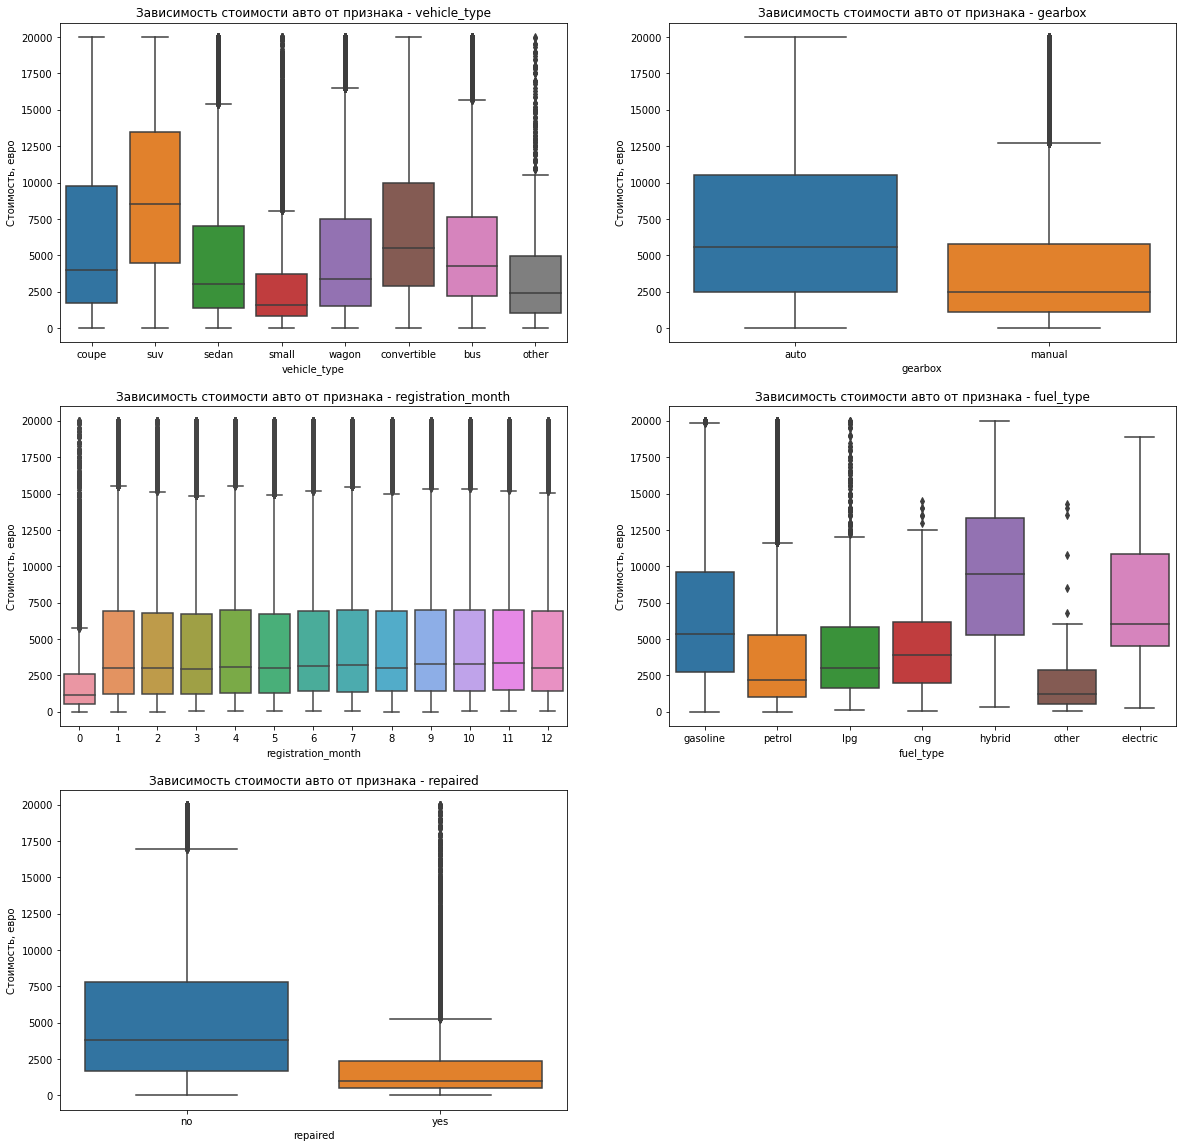

In [25]:
# определим список категориальных признаков для построения графиков boxplot
cols_for_boxgraph = ['vehicle_type', 'gearbox', 'registration_month', 'fuel_type', 'repaired']
plt.figure(figsize=(20, 20))
for i, col in enumerate(cols_for_boxgraph):
    plt.subplot(3, 2, i+1)
    sns.color_palette("pastel")
    sns.boxplot(x=col, y='price', data=df_train, )
    plt.ylabel('Стоимость, евро')
    plt.title(f'Зависимость стоимости авто от признака - {col}')
plt.show();

Выявлены следующие особенности:
- cамая высокая стоимость атвомобилей с типом кузова **`suv`**, самая низкая у **`small`**;
- стоимость автомобилей с **`автоматической`** коробкой передач выше, чем с **`ручной`**;
- признак `'registration_month'` практически не влияет на стоимость авто, что в принципе логично;
- тип топлива авто влияет на стоимость. Так у автомобилей с **`гибридным`** двигателем стоимость значительно выше остальных. Cтоимость машин с **`электрическим`** приводом и работающих на **`газе`** так же высока, а вот работающих на **`бензине`** или с пометкой **`other`** значительно ниже;
- стоимость автомобилей **`без ремонта`** выше, чем **`с ремонтом`**, что вполне объяснимо.

Далее будут построены парные графики распределения целевого признака `'price'` c такими признаками как `'registration_year'`, `'power'`, `'kilometer'` и `'postal_code'`.

/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


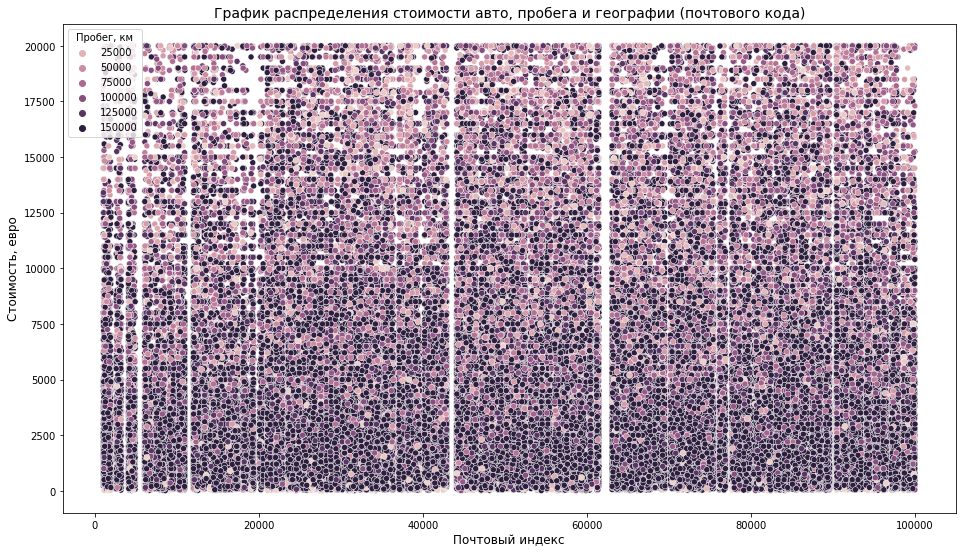

In [26]:
# построим график распределения стоимости авто, пробега и географии (почтового кода)
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df_train, x='postal_code', y='price', hue='kilometer')
plt.title(f'График распределения стоимости авто, пробега и географии (почтового кода)', fontsize=14)
plt.xlabel('Почтовый индекс', fontsize=12)
plt.ylabel('Стоимость, евро', fontsize=12)
plt.legend(title='Пробег, км')
plt.show();

Из графика видно:
- чем меньше пробег авто, тем больше объявлений с высокой стоимостью продажи;
- с почтовым индексом до **`20000`** объявлений с высокой стоимостью относительно меньше, чем в остальной выборке.

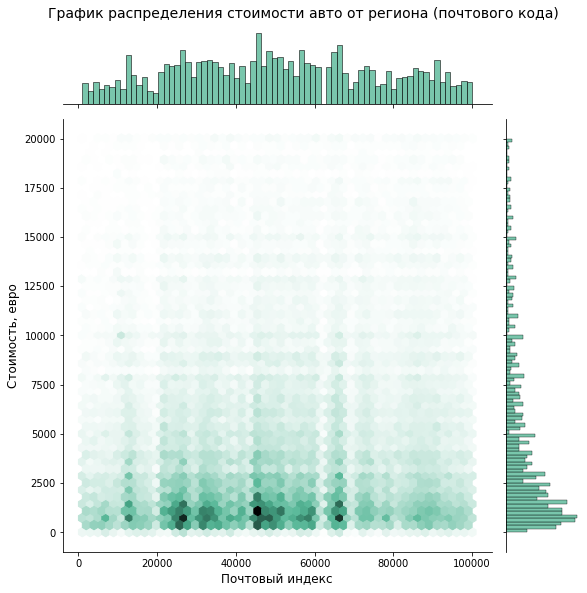

In [27]:
# построим график распределения стоимости авто от региона (почтового кода)
ax = sns.jointplot(data=df_train, x='postal_code', y='price', kind='hex', height=8, color='#4CB391')
ax.fig.suptitle('График распределения стоимости авто от региона (почтового кода)', fontsize=14, y=1.02)
ax.set_axis_labels('Почтовый индекс', 'Стоимость, евро', fontsize=12)
plt.show();

На графике хорошо видно, что в определенных регионах (диапазоне почтовых адресов от `20000` до `70000`) объявлений с низкой стоимостью продажи (до **`2500`** евро) больше, чем в остальных. Так же в этих регионах чаще встречаются объявления со стоимостью продажи от **`2500`** до **`9000`** евро.

Можно сказать что признак `'postal_code'`, определяющий географическую характеристику объектов, имеет потенциальную значимость для обучения моделей. Так как по значениям данного признака можно с уверенностью сказать что база данных взята по стране `USA` для сокращения уникальных значений признака предлагается оставить только первые 3 или 2 цифры кода, отвечающих за региональную принадлежность в рамках размера штата.

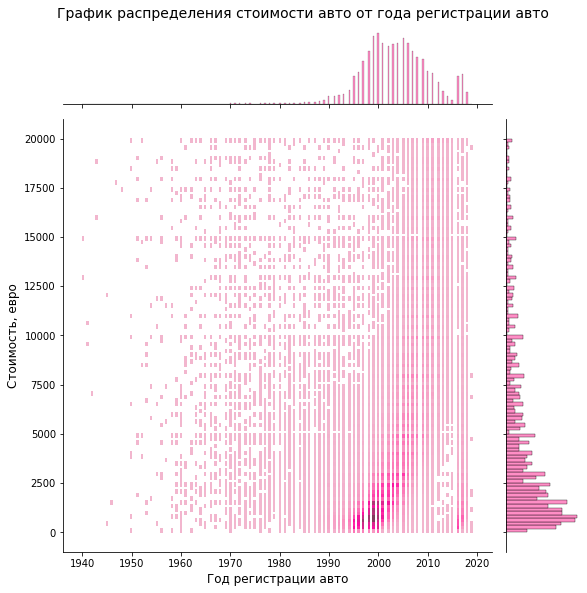

In [28]:
# построим график распределения стоимости авто от года регистрации авто
# чтобы исключить выбросы ограничим значения по году регистрации в диапазоне от 1940 до 2020
x_year = df_train.query('registration_year >= 1940 and registration_year <= 2020')['registration_year']
y_price = df_train['price']
ax = sns.jointplot(data=df_train, x=x_year, y=y_price, kind='hist', height=8, color='#FF69B4')
ax.fig.suptitle('График распределения стоимости авто от года регистрации авто', fontsize=14, y=1.02)
ax.set_axis_labels('Год регистрации авто', 'Стоимость, евро', fontsize=12)
plt.show();

На графикае распределения можно увидеть что:
- большая плотность объявлений сосредоточена в диапазоне `1995 - 2010гг`. со стоимостью до **`5000`** евро. Причем видна тендеция к росту стоимости автомобилей, год регистрации которых больше (ближе к `2010` году);
- чем старше год регистрации авто, тем меньше объявлений с высокой стоимостью.

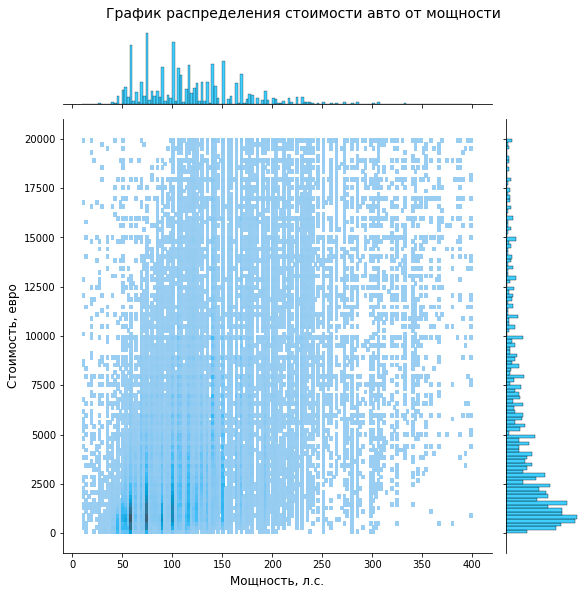

In [31]:
# построим график распределения стоимости авто от его мощности
# чтобы исключить выбросы ограничим значения по мощности в диапазоне от 10 до 400
x_power = df_train.query('power >= 10 and power <= 400')['power']
ax = sns.jointplot(x=x_power, y=y_price, kind='hist', height=8, color="#00BFFF")
ax.fig.suptitle('График распределения стоимости авто от мощности', fontsize=14, y=1.02)
ax.set_axis_labels('Мощность, л.с.', 'Стоимость, евро', fontsize=12)
plt.show();

На графике распределения можно увидеть что:
- большая плотность объявлений сосредоточена в диапазоне `45 - 150 л.с.`. со стоимостью до **`5000`** евро; 
- среди объявлений, в которых мощность автомобиля выше, чаще можно встретить объявления с более высокой стоимостью. Так, например, очень редко можно встретить объявления с высокой стоимостью авто мощностью `до 100 л.с.` и, наоборот, чаще попадаются объявления с высокой стоимостью авто, мощность которых `выше 300 л.с.`

Далее будут построены два графика со средней стоимостью автомобилей в зависимости от их `'марки'` и `'модели'`. Ранжирование средней стоимости от большей к меньшей позволит в дальнейшем численно закодировать признаки `'brand'` и `'model'` согласно метода **`OrdinalEncoder`**. 

Применение **`OneHotEncoding`** в текущей задаче не применимо, так как большая мощность множества значений по  признакам`'brand'` и `'model'` создаст большое разреженное признаковое пространство, что плохо отразится на обучение моделей на основе `дерева решений`.

In [44]:
df_train[df_train['registration_year'] <= 1920]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
78374,2016-04-04 20:39:52,250,other,1910,NaN,0,NaN,5000,1,NaN,audi,NaN,2016-04-04,0,99947,2016-04-06 22:46:27
70847,2016-03-28 18:57:27,100,NaN,1255,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-03-28,0,59069,2016-04-07 01:16:10
213499,2016-03-08 12:06:22,380,NaN,1000,NaN,0,6er,5000,0,NaN,bmw,NaN,2016-03-08,0,35102,2016-04-06 00:16:56
60017,2016-03-10 12:38:01,80,NaN,1000,NaN,0,NaN,5000,0,NaN,volkswagen,NaN,2016-03-10,0,93107,2016-04-07 04:45:57
214830,2016-03-24 17:53:28,1600,NaN,1600,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-03-24,0,46399,2016-03-29 04:17:04
192705,2016-03-31 15:47:24,20,NaN,1000,NaN,0,156,5000,0,NaN,alfa_romeo,NaN,2016-03-31,0,31224,2016-04-06 08:46:00
125577,2016-03-15 18:38:53,7750,NaN,1001,NaN,0,other,5000,0,NaN,citroen,NaN,2016-03-15,0,66706,2016-04-06 18:47:20
221736,2016-03-15 14:52:20,1500,NaN,1039,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-15,0,44147,2016-03-16 12:15:21
53577,2016-03-20 11:44:28,330,NaN,1000,NaN,0,polo,5000,0,NaN,volkswagen,NaN,2016-03-20,0,45259,2016-04-04 08:17:15
135865,2016-03-07 14:59:17,16500,NaN,1000,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-03-07,0,23879,2016-03-09 19:15:47


In [74]:
df_train['registration_year'].mask(df_train['registration_year'] <= 1900, other=1900, inplace=True)
df_train['registration_year'].mask(df_train['registration_year'] >= 2016, other=2016, inplace=True)

/opt/conda/lib/python3.9/site-packages/pandas/core/generic.py:9286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(
/opt/conda/lib/python3.9/site-packages/pandas/core/generic.py:9286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(


In [76]:
year_binned = pd.cut(df_train['registration_year'], 3)
df_train['year_binned'] = year_binned
df_train.groupby('year_binned')['price'].mean()

/tmp/ipykernel_78/833401375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['year_binned'] = year_binned


year_binned
(1899.884, 1938.667]    3950.746835
(1938.667, 1977.333]    7714.575258
(1977.333, 2016.0]      4546.935118
Name: price, dtype: float64

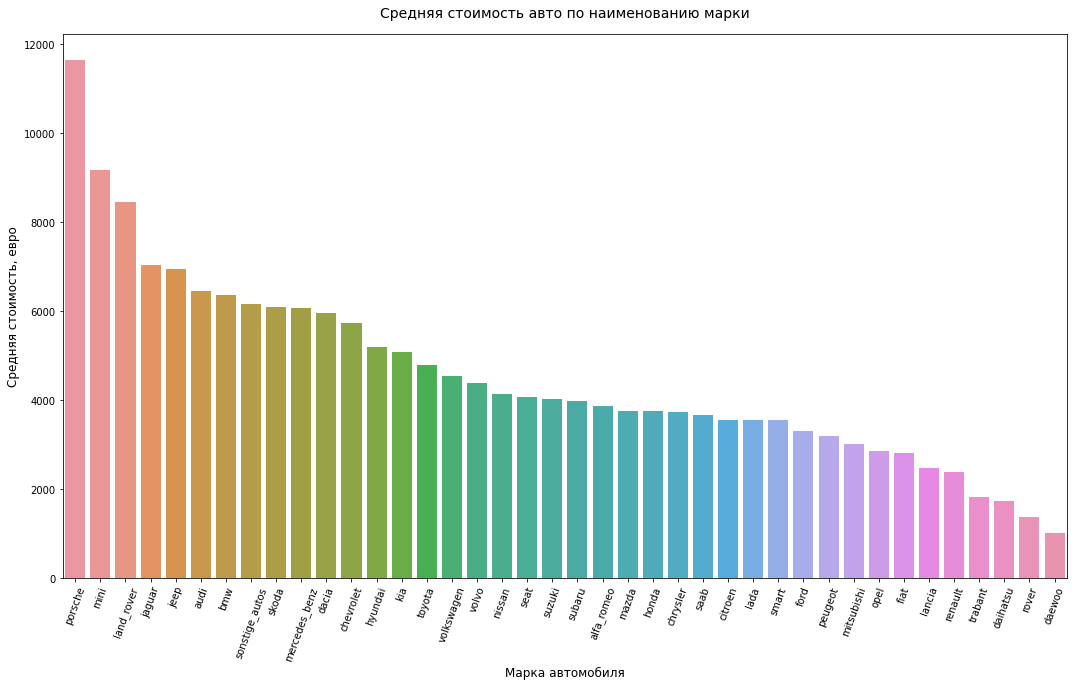

In [17]:
# построим график средней стоимости авто в зависимости от его марки
plt.figure(figsize=(18, 10))
df_brand = pd.DataFrame(df_train.groupby(['brand'])['price'].mean().sort_values(ascending = False))
sns.barplot(data=df_brand, x=df_brand.index, y='price')
plt.xticks(rotation=70)
plt.title('Средняя стоимость авто по наименованию марки', fontsize=14, y=1.02)
plt.ylabel('Средняя стоимость, евро', fontsize=12)
plt.xlabel('Марка автомобиля', fontsize=12)
plt.show();

График ранжирован по средней стоимости от самой высокой к наименьшей:
- самая высокая средняя стоимость авто у марок **`porche`**, **`mini`**, **`land_rover`**;
- наименьшая средняя стоимость авто у марки **`daewoo`**.

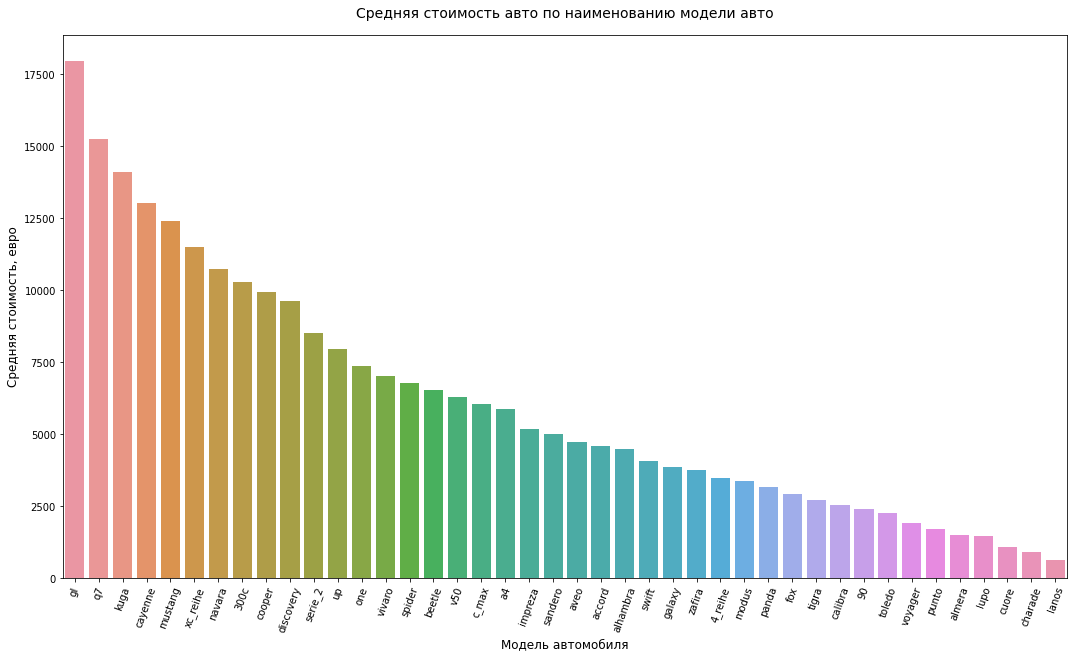

In [18]:
# построим график средней стоимости авто в зависимости от модели
plt.figure(figsize=(18, 10))
df_model = pd.DataFrame(df_train.groupby(['model'])['price'].mean().sort_values(ascending = False))[::6]
sns.barplot(data=df_model, x=df_model.index, y='price')
plt.xticks(rotation=70)
plt.title('Средняя стоимость авто по наименованию модели авто', fontsize=14, y=1.02)
plt.ylabel('Средняя стоимость, евро', fontsize=12)
plt.xlabel('Модель автомобиля', fontsize=12)
plt.show();

График ранжирован по средней стоимости от самой высокой к наименьшей:
- самая высокая средняя стоимость авто у модели **`gl`**.

### Обработка пропусков

In [19]:
# определим сколько пропущенных значений имеет каждый признак в обучающей выборке
pd.DataFrame({'Количество пропусков': df_train.isna().sum(), 'Процент пропусков': df_train.isna().mean() * 100})

,Количество пропусков,Процент пропусков
date_crawled,0,0.000000
price,0,0.000000
vehicle_type,19937,9.708743
registration_year,0,0.000000
gearbox,10101,4.918895
power,0,0.000000
model,10271,5.001680
kilometer,0,0.000000
registration_month,0,0.000000
fuel_type,17326,8.437261


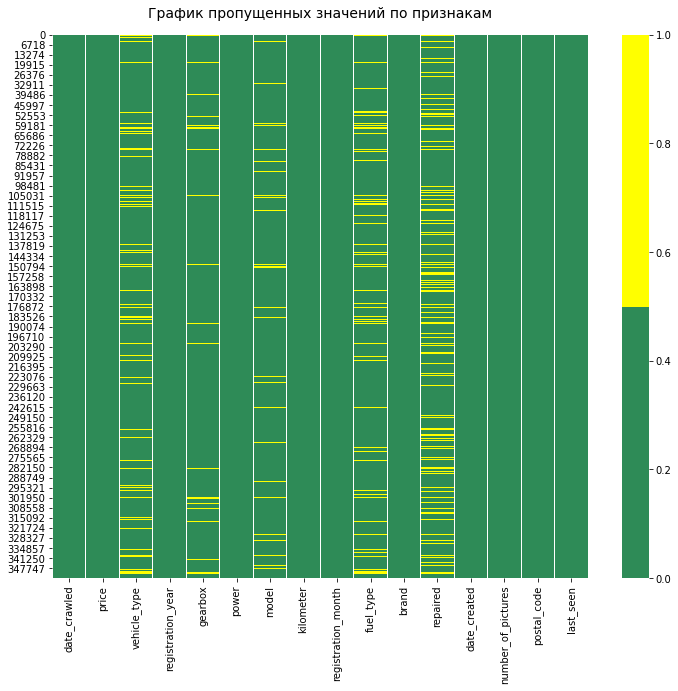

In [20]:
# построим тепловую карту для отображения пропусков 
colours = ['#2E8B57', '#ffff00'] 
plt.figure(figsize=(12, 10))
sns.heatmap(df_train.isnull().sort_index(), cmap=sns.color_palette(colours))
plt.title('График пропущенных значений по признакам', fontsize=14, y=1.02)
plt.show();

В обучающих данных имеются пропуски:
- по признаку `'vehicle_type'` 19937 пропущенных значений (≈9,7 %);
- по признаку `'gearbox'` 10101 пропущенных значений (≈4,9 %);
- по признаку `'model'` 10271 пропущенных значений (≈5,0 %);
- по признаку `'fuel_type'` 17326 пропущенных значений (≈8,5 %);
- по признаку `'repaired'` 38981 пропущенных значений (≈19,0 %).

Так же стоит отметить, что среди всех записей пропуски в данных распределены практически равномерно, что в свою очередь может говорить об их случайной природе. Исходя из графика можно предположить, что некоторые записи имеют одновременно несколько пропусков по категориальным признакам.  

In [87]:
df_train[['vehicle_type', 'model', 'gearbox', 'fuel_type', 'repaired']].isnull().corr()

,vehicle_type,model,gearbox,fuel_type,repaired
vehicle_type,1.000000,0.171191,0.277543,0.417590,0.283115
model,0.171191,1.000000,0.126212,0.206278,0.138446
gearbox,0.277543,0.126212,1.000000,0.259712,0.240331
fuel_type,0.417590,0.206278,0.259712,1.000000,0.222893
repaired,0.283115,0.138446,0.240331,0.222893,1.000000


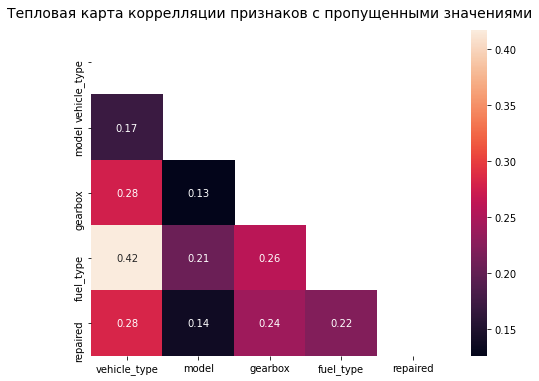

In [23]:
# построим тепловую карту пропущенных значений
plt.figure(figsize=(8, 6))
matrix = np.triu(np.ones(5))
sns.heatmap(df_train[['vehicle_type', 'model', 'gearbox', 'fuel_type', 'repaired']].isnull().corr(), annot=True, mask=matrix)
plt.title('Тепловая карта коррелляции признаков с пропущенными значениями', fontsize=14, y=1.02)
plt.show();

Из матрицы коррелляции видно:
- корреляция пропусков близка к нулю практически для всех признаков. Другими словами, пропуски одного признака не влияют на пропуски другого;
- есть небольшая прямая линейная связь между наличием значений в признаках `'fuel_type'` и `'vehicle_type'`. Т.е. если присутствуют значения одного признака, то есть шанс что присутствуют значения и другого.

In [22]:
# определим сколько записей имеют одновременно пропусков в данных
# сначала создаем индикатор для признаков с пропущенными данными
for col in df_train.columns:
    missing = df_train[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print('created missing indicator for: {}'.format(col))
        df_train['{}_ismissing'.format(col)] = missing

# затем на основе индикатора строим гистограмму
ismissing_cols = [col for col in df_train.columns if 'ismissing' in col]
df_train['missing_counts'] = df_train[ismissing_cols].sum(axis=1)

# df_train['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')
df_train['missing_counts'].value_counts().reset_index().sort_values(by='index')

created missing indicator for: vehicle_type
created missing indicator for: gearbox
created missing indicator for: model
created missing indicator for: fuel_type
created missing indicator for: repaired


/tmp/ipykernel_48/1005699121.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['{}_ismissing'.format(col)] = missing
/tmp/ipykernel_48/1005699121.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['missing_counts'] = df_train[ismissing_cols].sum(axis=1)


,index,missing_counts
0,0,145368
1,1,36630
2,2,14476
3,3,5307
4,4,2737
5,5,833


В обучающей выборке есть записи, имеющие более 4-х пропусков одновременно. В таком случае такие записи будут малоинформативны для моделей, а так же для возможного восстановления пропусков. Такие записи будут удалены из обучающей выборки.

По оостальным записям в связи с тем, что пропусков в данных достаточно много и их удаление может привести к потере значительной информации для обучения моделей необходимо заполнить пропуски. Наиболее важным и ценным при обработке пропусков в исходных данных является не полное избавление от них, связанное с заполнением средним и медианным значением или удалением, а нахождение связей с другими имеющимися данными, чтобы заполнить их более реальными значениями, не допустив значительных искажений в исходных данных. Таким образом если по каким-то пропускам нет больше возможностей к нахождению приближенных значений можно заменить пропуски на константные значения. Логично предположить, что признак `'vehicle_type'` (тип автомобильного кузова) можно востановить по признакам `'brand'` и `'model'`. Но в связи с тем, что одним из важных условий задачи является быстродействие работы модели при обучении и предсказании, а восстановление пропусков по другим признакам с использваонием метода `fillna()` и `apply()` очень ресурсозатратны, то предлагается пропуски в признаках `'vehicle_type'`, `'model'`, `'gearbox'`, `'fuel_type'`,  `'repaired'` заменить на константные значения (`'other'` и  `'unknown'`).

In [23]:
# оставим в обучающей выборке только те записи, которые не имеют более 3-х пропусков
# в категориальных признаках
df_train = df_train[df_train['missing_counts'] < 4]
# удалим вновь созданные признаки для подсчета пропусков, оставив только изначальные
df_train = df_train[df.columns]
pd.DataFrame({'Количество пропусков': df_train.isna().sum(), 'Процент пропусков': df_train.isna().mean() * 100})

,Количество пропусков,Процент пропусков
date_crawled,0,0.000000
price,0,0.000000
vehicle_type,16519,8.186598
registration_year,0,0.000000
gearbox,6979,3.458700
power,0,0.000000
model,8557,4.240736
kilometer,0,0.000000
registration_month,0,0.000000
fuel_type,13974,6.925330


Оставшиеся пропукси будут обработаны на этапе препроцессинга данных в pipeline.

## Обучение моделей

Далее будут обучены **5 моделей**: *базовая модель* - **DecisionTree** и модели основанные на ансамблировании - **'RandomForest', 'XGBoost', 'CatBoost', 'LightGBM'**. Так как на начальном этапе уже была выделена валидационная выборка для "подгонки" (нахождения лучших значений гиперпараметров) моделей, будет использован собственный алгоритм для оценивания модели. Метрика для оценки качества по условиям задачи - **`RMSE`**. 

В связи с тем, что у каждой модели собственные гиперпараметры и время нахождения их зависит так же от диапазона и масштаба подбора, время обучения моделей будет оцениваться на уже подобранных значениях гиперпараметров для более честного сравнения.

### Pipeline

Для начала будет написан свой класс предобработки данных, который будет выполнятся на первом этапе **Pipeline**.

In [24]:
# напишем свой класс для предобработки данных для использования в pipeline
class DataPreprocess(BaseEstimator, TransformerMixin):
    
    # инициализация объекта
    def __init__(self, encoding=True):
        # определяем флаг необходимости порядкого кодирования
        self.encode = encoding
    
    # метод возвращающий ранжированный по средней стоимости авто словарь по переданному признаку
    def get_rank_dict(self, df, col):
        sort_ = df.groupby(col)['price'].mean().sort_values(ascending = False).index
        return {n: i for i, n in enumerate(sort_)}
    
    # метод для восстановления пропусков в признаке vehicle_type
    def get_vehicle_type(self, row):
        try:
            self.vehicle_dict[row['brand'], row['model']]
        except:
            return 'unknown'
        if self.vehicle_dict[row['brand'], row['model']].index[0] or row['model'] != 'other':
            return self.vehicle_dict[row['brand'], row['model']].index[0]
        else:
            return 'unknown'
    
    # метод собственного порядкового кодирования для признаков brand и model
    # с учетом ранжирования по средней стоимости авто
    def set_ord_encode(self, diction, col):
        diff_dict = (set(diction) ^ set(self.data_transform[col]))
        # если в данных обнаруживается неизвестная категория
        if diff_dict:
            # присваиваем таким категориям следующее число увеличенное на 1
            for n in diff_dict:
                diction[n] = len(diction) + 1
        self.data_transform[col] = self.data_transform[col].replace(diction)
    
    # метод для заполнения пропусков константными значениями
    def imputer(self):
        self.data_transform['model'].fillna('other', inplace=True)
        self.data_transform['vehicle_type'].fillna('unknown', inplace=True)
        self.data_transform['gearbox'].fillna('unknown', inplace=True)
        self.data_transform['fuel_type'].fillna('unknown', inplace=True)
        self.data_transform['repaired'].fillna('unknown', inplace=True)
        self.data_transform['postal_code'] = self.data_transform['postal_code'] // 1000
    
    # метод fit 
    def fit(self, X, y=None):
        # создадим словарь с наиболее часто встречающимися значениями признака vehicle_type
        # используя для этого признаки марки и модели авто
        # self.vehicle_dict = X.groupby(['brand', 'model'])['vehicle_type'].value_counts()
        # создадим словари с ранжированными значениями признаков по средней стоимости авто
        # для порядкого кодирования при вызове метода transform если encoding = True
        if self.encode:
            df = pd.concat([X, y], axis=1)
            self.brand_dict = self.get_rank_dict(df, 'brand')
            self.model_dict = self.get_rank_dict(df, 'model')
            self.vehicle_dict = self.get_rank_dict(df, 'vehicle_type')
            self.fuel_dict = self.get_rank_dict(df, 'fuel_type')
        return self
    
    # метод transform 
    def transform(self, X, y=None):
        self.data_transform = X.copy()
        # заполним пропуски на константные значения с помощью метода imputer()
        self.imputer()
        # заменим пропуски в признаке vehicle_type на основе созданного словаря self.vehicle_dict
        # данный метод заглушен так как значительно увеличивает время на обучение при малом приросте качества
        # self.data_transform['vehicle_type'].fillna(self.data_transform[['brand', 'model']] \
        #                                           .apply(self.get_vehicle_type, axis=1), inplace=True)
        # применим собственное порядковое кодирование основанное на ранжировании если encoding = True
        if self.encode:
            self.set_ord_encode(self.brand_dict, col='brand')
            self.set_ord_encode(self.model_dict, col='model')
            self.set_ord_encode(self.vehicle_dict, col='vehicle_type')
            self.set_ord_encode(self.fuel_dict, col='fuel_type')
        return self.data_transform
       
    # метод для получения траснформированного df для отладки    
    def _get_df(self):
        return self.data_transform
        

In [25]:
# разобъем обучающую выборку на таргет и фичи
y_train = df_train['price']
X_train = df_train.drop('price', axis=1)

# определим признаки для собственного препроцессинга (порядкого кодирования)
handle_cat_cols = ['brand', 'model', 'vehicle_type', 'fuel_type']
# определим остальные категориальные признаки
cat_cols = ['gearbox', 'repaired']
# определим числовые признаки
num_cols = ['registration_year', 'power', 'kilometer', 'postal_code']

# создаем объект нашего препроцессора
data_preprocess = DataPreprocess()

# предообработка категориальных признаков с помощью OrdinalEncoder
categorical_transformer = Pipeline(steps=[
    ('ord_enc', OrdinalEncoder(handle_unknown='ignore'))
])

# совместная предобработка данных 
columns_transformer = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('handle', 'passthrough', handle_cat_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

### Модель DecisionTreeRegressor

Подбор гиперпараметров для модели **DecisionTreeRegressor**.

In [26]:
%%time

best_score = 2500
for max_d in range(10, 16, 1):
    # обучим модель для каждой комбинации значений гиперпараметров
    model_DT = DecisionTreeRegressor(random_state=RAND_ST, max_depth=max_d)
    pipeline_DT = Pipeline(steps=[('data_prep', data_preprocess),
                                  ('cols_transformer', columns_transformer),
                                  ('model_DT', model_DT)
                                 ])
    pipeline_DT.fit(X_train, y_train)
    # получим предсказания на валидационной выборке 
    preds = pipeline_DT.predict(X_valid)
    # получим оценку RMSE
    score = np.sqrt(mean_squared_error(y_valid, preds))
    # если мы полуичли оценку лучше чем на предыдущей итерации 
    # сохраним данную модель как лучшую, а так же обновим best_score
    if score < best_score:
        best_score = score
        best_parameters = {'max_depth': max_d}

score_DT = best_score        

print('Best score (RMSE): {:.2f}'.format(score_DT))
print('Best parameters: {}'.format(best_parameters))

Best score (RMSE): 1931.52
Best parameters: {'max_depth': 13}
CPU times: user 18.2 s, sys: 226 ms, total: 18.4 s
Wall time: 18.4 s


- Лучшая модель с гиперпараметром **`max_depth`** - **13**.
- Метрика **RMSE** - **1931,52**.

Оценка времени обучения модели будет проведена на обучающей и валидационной выборках при подобранных значениях гиперпараметров. Оценка времени предсказания в рамках постановки задачи будет проводится на валидационной выборке.

In [27]:
%%time
start = time.time()

model_DT = DecisionTreeRegressor(random_state=RAND_ST, max_depth=13)
pipeline_DT = Pipeline(steps=[('data_prep', data_preprocess),
                              ('cols_transformer', columns_transformer),
                              ('model_DT', model_DT)
                             ])
pipeline_DT.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

end = time.time()
train_time_DT=round(end-start,2)
print(f'Время обучения модели: {train_time_DT} сек')

start = time.time()
# получим предсказания на валидационной выборке 
preds = pipeline_DT.predict(X_valid)
end = time.time()
predict_time_DT=round(end-start,2)
print(f'Время предсказания модели: {predict_time_DT} сек')

Время обучения модели: 3.51 сек
Время предсказания модели: 0.67 сек
CPU times: user 4.08 s, sys: 92.4 ms, total: 4.17 s
Wall time: 4.17 s


### Модель RandomForestRegressor

Подбор гиперпараметров для модели **RandomForestRegressor**.

In [28]:
%%time

best_score = 2500
for max_d in range(18, 30, 2):
    # обучим модель для каждой комбинации значений гиперпараметров
    model_RF = RandomForestRegressor(random_state=RAND_ST, max_depth=max_d, n_jobs=-1)
    pipeline_RF = Pipeline(steps=[('data_prep', data_preprocess),
                                  ('cols_transformer', columns_transformer),
                                  ('model_RF', model_RF)
                                 ])
    pipeline_RF.fit(X_train, y_train)
    # получим предсказания на валидационной выборке 
    preds = pipeline_RF.predict(X_valid)
    # получим оценку RMSE
    score = np.sqrt(mean_squared_error(y_valid, preds))
    # если мы полуичли оценку лучше чем на предыдущей итерации 
    # сохраним данную модель как лучшую, а так же обновим best_score
    if score < best_score:
        best_score = score
        best_parameters = {'max_depth': max_d}

score_RF = best_score            
            
print('Best score (RMSE): {:.2f}'.format(score_RF))
print('Best parameters: {}'.format(best_parameters))

Best score (RMSE): 1622.12
Best parameters: {'max_depth': 22}
CPU times: user 6min 59s, sys: 4.51 s, total: 7min 3s
Wall time: 7min 4s


- Лучшая модель с гиперпараметрами **`n_estimators`** - **100**, **`max_depth`** - **22**.
- Метрика **RMSE** - **1622.12**.

Оценка времени обучения модели будет проведена на обучающей и валидационной выборках при подобранных значениях гиперпараметров. Оценка времени предсказания в рамках постановки задачи будет проводится на валидационной выборке.

In [29]:
%%time
start = time.time()

model_RF = RandomForestRegressor(random_state=RAND_ST, max_depth=22, n_jobs=-1)
pipeline_RF = Pipeline(steps=[('data_prep', data_preprocess),
                              ('cols_transformer', columns_transformer),
                              ('model_RF', model_RF)
                             ])
pipeline_RF.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

end = time.time()
train_time_RF=round(end-start,2)
print(f'Время обучения модели: {train_time_RF} сек')

start = time.time()
# получим предсказания на валидационной выборке 
preds = pipeline_RF.predict(X_valid)
end = time.time()
predict_time_RF=round(end-start,2)
print(f'Время предсказания модели: {predict_time_RF} сек')

Время обучения модели: 102.06 сек
Время предсказания модели: 3.24 сек
CPU times: user 1min 43s, sys: 1.23 s, total: 1min 44s
Wall time: 1min 45s


### Модель XGBRegressor

Подбор гиперпараметров для модели **XGBRegressor**.

In [30]:
%%time

best_score = 2500
for learn in [0.25]: # np.arange(0.1, 0.4, 0.05)
    for n_est in [250]: # range(100, 500, 50)
        for max_d in [5]: # [2, 3, 4, 5]
            # обучим модель для каждой комбинации значений гиперпараметров
            model_XGB = XGBRegressor(random_state=RAND_ST, 
                                     learning_rate=learn, 
                                     n_estimators=n_est, 
                                     max_depth=max_d,
                                     n_jobs=-1)
            pipeline_XGB = Pipeline(steps=[('data_prep', data_preprocess),
                                          ('cols_transformer', columns_transformer),
                                          ('model_XGB', model_XGB)
                                         ])
            pipeline_XGB.fit(X_train, y_train)
            # получим предсказания на валидационной выборке 
            preds = pipeline_XGB.predict(X_valid)
            # получим оценку RMSE
            score = np.sqrt(mean_squared_error(y_valid, preds))
            # если мы полуичли оценку лучше чем на предыдущей итерации 
            # сохраним данную модель как лучшую, а так же обновим best_score
            if score < best_score:
                best_score = score
                best_parameters = {'learning_rate': learn, 'n_estimators': n_est, 'max_depth': max_d}

score_XGB = best_score              
                
print('Best score (RMSE): {:.2f}'.format(score_XGB))
print('Best parameters: {}'.format(best_parameters))

Best score (RMSE): 1648.45
Best parameters: {'learning_rate': 0.25, 'n_estimators': 250, 'max_depth': 5}
CPU times: user 4min 1s, sys: 2.77 s, total: 4min 3s
Wall time: 4min 5s


- Лучшая модель с гиперпараметрами: **`learning_rate`** - **0.25**, **`n_estimators`** - **250**, **`max_depth`** - **5**.
- Метрика **RMSE** - **1648.45**.

Оценка времени обучения модели будет проведена на обучающей и валидационной выборках при подобранных значениях гиперпараметров. Оценка времени предсказания в рамках постановки задачи будет проводится на валидационной выборке.

In [31]:
%%time
start = time.time()

model_XGB = XGBRegressor(random_state=RAND_ST, 
                            learning_rate=0.25, 
                            n_estimators=250, 
                            max_depth=5,
                            n_jobs=-1)
pipeline_XGB = Pipeline(steps=[('data_prep', data_preprocess),
                               ('cols_transformer', columns_transformer),
                               ('model_XGB', model_XGB)
                              ])
pipeline_XGB.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

end = time.time()
train_time_XGB=round(end-start,2)
print(f'Время обучения модели: {train_time_XGB} сек')

start = time.time()
# получим предсказания на валидационной выборке 
preds = pipeline_XGB.predict(X_valid)
end = time.time()
predict_time_XGB=round(end-start,2)
print(f'Время предсказания модели: {predict_time_XGB} сек')

Время обучения модели: 266.83 сек
Время предсказания модели: 1.0 сек
CPU times: user 4min 23s, sys: 2.89 s, total: 4min 26s
Wall time: 4min 27s


### Модель CatBoostRegressor

Подбор гиперпараметров для модели **CatBoostRegressor**.

In [32]:
%%time

# создаем объект нашего препроцессора без порядкого кодирования
data_preprocess_cat = DataPreprocess(encoding=False)

best_score = 2500
for learn in [0.3]: # np.arange(0.1, 0.5, 0.1)
    for n_est in [900]: # range(100, 1000, 100)
        # обучим модель для каждой комбинации значений гиперпараметров
        model_CB = CatBoostRegressor(random_state=RAND_ST, 
                                     learning_rate=learn, 
                                     n_estimators=n_est,
                                     verbose=False,
                                     cat_features=handle_cat_cols+cat_cols)
        pipeline_CB = Pipeline(steps=[('data_prep', data_preprocess_cat),
                                      ('model_CB', model_CB)
                                     ])
        pipeline_CB.fit(X_train, y_train)
        # получим предсказания на валидационной выборке 
        preds = pipeline_CB.predict(X_valid)
        # получим оценку RMSE
        score = np.sqrt(mean_squared_error(y_valid, preds))
        # если мы получили оценку лучше чем на предыдущей итерации 
        # сохраним данную модель как лучшую, а так же обновим best_score
        if score < best_score:
            best_score = score
            best_parameters = {'learning_rate': learn, 'n_estimators': n_est}

score_CB = best_score
            
print('Best score (RMSE): {:.2f}'.format(score_CB))
print('Best parameters: {}'.format(best_parameters))

Best score (RMSE): 1590.46
Best parameters: {'learning_rate': 0.3, 'n_estimators': 900}
CPU times: user 3min 26s, sys: 1.77 s, total: 3min 28s
Wall time: 3min 31s


- Лучшая модель с гиперпараметрами: **`learning_rate`** - **0.3**, **`n_estimators`** - **900**.
- Метрика **RMSE** - **1590.46**.

Оценка времени обучения модели будет проведена на обучающей и валидационной выборках при подобранных значениях гиперпараметров. Оценка времени предсказания в рамках постановки задачи будет проводится на валидационной выборке.

In [33]:
%%time
start = time.time()

model_CB = CatBoostRegressor(random_state=RAND_ST, 
                             learning_rate=0.3, 
                             n_estimators=900,
                             verbose=False,
                             cat_features=handle_cat_cols+cat_cols)
pipeline_CB = Pipeline(steps=[('data_prep', data_preprocess_cat),
                              ('model_CB', model_CB)
                             ])
pipeline_CB.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid])) 

end = time.time()
train_time_CB=round(end-start,2)
print(f'Время обучения модели: {train_time_CB} сек')

start = time.time()
# получим предсказания на валидационной выборке 
preds = pipeline_CB.predict(X_valid)
end = time.time()
predict_time_CB=round(end-start,2)
print(f'Время предсказания модели: {predict_time_CB} сек')

Время обучения модели: 282.82 сек
Время предсказания модели: 0.83 сек
CPU times: user 4min 37s, sys: 2.22 s, total: 4min 39s
Wall time: 4min 43s


### Модель LGBMRegressor

Подбор гиперпараметров для модели **LGBMRegressor**.

In [34]:
%%time

best_score = 2500
for learn in [0.1]: # np.arange(0.1, 0.5, 0.1)
    for num_leav in [250]: # range(100, 260, 20)
        # обучим модель для каждой комбинации значений гиперпараметров
        model_LGBM = LGBMRegressor(random_state=RAND_ST,
                                   learning_rate=learn, 
                                   num_leaves=num_leav,
                                   n_jobs=-1)
        pipeline_LGBM = Pipeline(steps=[('data_prep', data_preprocess),
                                        ('cols_transformer', columns_transformer),
                                        ('model_LGBM', model_LGBM)
                                       ])
        pipeline_LGBM.fit(X_train, y_train)
        # получим предсказания на валидационной выборке 
        preds = pipeline_LGBM.predict(X_valid)
        # получим оценку RMSE
        score = np.sqrt(mean_squared_error(y_valid, preds))
        # если мы получили оценку лучше чем на предыдущей итерации 
        # сохраним данную модель как лучшую, а так же обновим best_score
        if score < best_score:
            best_score = score
            best_parameters = {'learning_rate': learn, 'num_leaves': num_leav}

score_LGBM = best_score
            
print('Best score (RMSE): {:.2f}'.format(score_LGBM))
print('Best parameters: {}'.format(best_parameters))

Best score (RMSE): 1608.34
Best parameters: {'learning_rate': 0.1, 'num_leaves': 250}
CPU times: user 11min 23s, sys: 8.2 s, total: 11min 31s
Wall time: 11min 34s


- Лучшая модель с гиперпараметрами: **`learning_rate`** - **0.1**, **`num_leaves`** - **250**.
- Метрика **RMSE** - **1608.34**.

Оценка времени обучения модели будет проведена на обучающей и валидационной выборках при подобранных значениях гиперпараметров. Оценка времени предсказания в рамках постановки задачи будет проводится на валидационной выборке.

In [35]:
%%time
start = time.time()

model_LGBM = LGBMRegressor(random_state=RAND_ST,
                           learning_rate=0.1, 
                           num_leaves=250,
                           n_jobs=-1)
pipeline_LGBM = Pipeline(steps=[('data_prep', data_preprocess),
                                ('cols_transformer', columns_transformer),
                                ('model_LGBM', model_LGBM)
                               ])
pipeline_LGBM.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]))

end = time.time()
train_time_LGBM=round(end-start,2)
print(f'Время обучения модели: {train_time_LGBM} сек')

start = time.time()
# получим предсказания на валидационной выборке 
preds = pipeline_LGBM.predict(X_valid)
end = time.time()
predict_time_LGBM=round(end-start,2)
print(f'Время предсказания модели: {predict_time_LGBM} сек')

Время обучения модели: 830.31 сек
Время предсказания модели: 1.48 сек
CPU times: user 13min 34s, sys: 10.9 s, total: 13min 45s
Wall time: 13min 51s


## Анализ моделей

Для сравнения моделей результаты будут сведены в общую таблицу.

In [36]:
# создадим список обученных моделей
model_name = ['DecisionTreeRegressor',
              'RandomForestRegressor',
              'XGBRegressor',
              'CatBoostRegressor',
              'LGBMRegressor']
# создадим словарь с полученными результатами обучения моделей
score_list = [score_DT, score_RF, score_XGB, score_CB, score_LGBM]
train_time_list = [train_time_DT, train_time_RF, train_time_XGB, train_time_CB, train_time_LGBM]
pred_time_list = [predict_time_DT, 
                   predict_time_RF, 
                   predict_time_XGB, 
                   predict_time_CB, 
                   predict_time_LGBM]
data = {'RMSE на валидационной выборке': score_list,
        'Время обучения модели, сек': train_time_list,
        'Время предсказания модели, сек': pred_time_list}

# создадим датафрейм (таблицу) с результатами и выведем на экран
results_table = pd.DataFrame(data=data, index=model_name)
results_table

,RMSE на валидационной выборке,"Время обучения модели, сек","Время предсказания модели, сек"
DecisionTreeRegressor,1931.520741,3.51,0.67
RandomForestRegressor,1622.118028,102.06,3.24
XGBRegressor,1648.445132,266.83,1.00
CatBoostRegressor,1590.457107,282.82,0.83
LGBMRegressor,1608.340556,830.31,1.48


### Выбор лучшей модели

Для определения лучшей модели по трем парамтерам будет построен график оценки моделей по трем параметрам.

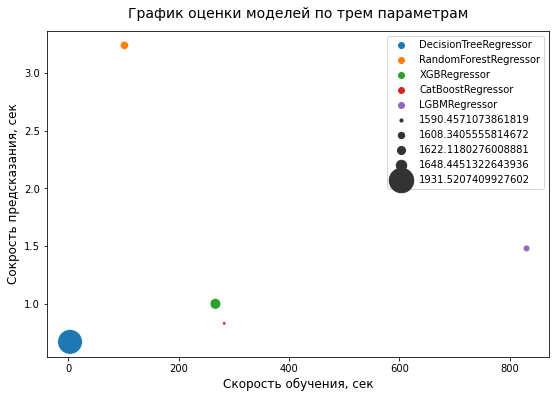

In [37]:
plt.figure(figsize=(9, 6))
sns.scatterplot(x=train_time_list, y=pred_time_list, hue=model_name, size=score_list, sizes=(10, 600))
plt.title('График оценки моделей по трем параметрам', fontsize=14, y=1.02)
plt.ylabel('Сокрость предсказания, сек', fontsize=12)
plt.xlabel('Скорость обучения, сек', fontsize=12)
plt.show();

Из графика и таблицы можно сделать следующие выводы:
- идеальная модель должна на графике располагаться как можно ближе к нижнему левому углу, при этом размер кружка должен быть наименьшим. Так как на шкале времени по оси `'y'` на порядок меньшие значения, чем на оси `'x'`, уход модели вверх не критичен;  
- наилучшая модель по метрике **`RMSE`** (наименьший размер кружка на графике) - **CatBoostRegressor**, но она в свою очередь тратит значительное время на обучение (порядка 282 сек), что по условиям задачи неприемлимо;
- самая быстрая в обучении и предсказании является базовая модель **DecisionTreeRegressor** (распологается в нижнем левом углу графика), но она имеет худший показатель по метрике **`RMSE`**. Так же модель построенная на одном деревне очень неустойчива при незначительном изменении входных данных (имеет очень большую дисперсию при предсказании в отличии от моделей, использующих ансамблирование);
- из оставшихся только модель **RandomForestRegressor** максимально подходит по условиям задачи: имеет хороший показатель **`RMSE`**, а так же небольшое время обучения и предсказания по сравнению с моделями, использующими бустинг.

Проверим качество модели **RandomForestRegressor** на тестовой выборке.

### Оценка лучшей модели на тестовой выборке

In [40]:
# получим предсказания на тестовой выборке 
test_prediction = pipeline_RF.predict(X_test)
test_score = np.sqrt(mean_squared_error(y_test, test_prediction))
print('Метрика качества RMSE на тестовой выборке:', test_score)

Метрика качества RMSE на тестовой выборке: 1572.8498732697515


### Важность признаков для предсказания стоимости авто

Ниже представлен график важности признаков в предсказании модели **LGBMRegressor**. 

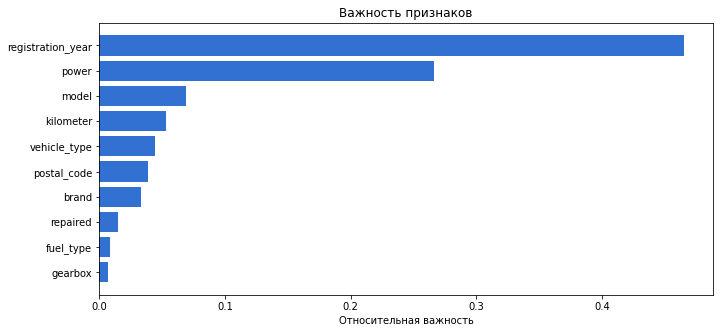

In [41]:
# построим график важности признаков в порядке убывания важности
features = pd.Series(num_cols+handle_cat_cols+cat_cols)
importances = pipeline_RF.named_steps['model_RF'].feature_importances_
indexes = np.argsort(importances)

plt.figure(figsize=(11, 5))
plt.title('Важность признаков')
plt.barh(range(len(indexes)), importances[indexes], color='#3271D1', align='center')
plt.yticks(range(len(indexes)), features[indexes])
plt.xlabel('Относительная важность')
plt.show()

Модель выделила следующие признаки:
- признаки `'год регистрации'` и `'мощность'` имеют самое высокое значение для предсказания стоимости авто;
- наименьшее значение для предсказания модели имеют признаки `'модель'`, `'пробег'`, `'тип кузова'`, `'почтовый адрес (географический регион продажи)'`, `'марка'`, `'был ли ремонт авто'`, `'тип топлива'` и `'коробка передач'` в порядке убывания значимости.  

## Общий вывод

В ходе работы было выполнено:

- загружены данные, проведена начальная предобработка (удалены объекты с аномально низкими значениями целевого признака, обработаны явные и неявные дубликаты);
- данные предварительно разбиты на обучающую, валидационную и тестовую выборки;
- проведен анализ данных (EDA-исследование);
- изученены и обработаны пропуски в данных;
- написан собственный класс для препроцессинга данных с использованием **`Pipeline`**;
- с предварительным подбором гиперпараметров обучены **5 моделей** на основе `'деревьев'`: **DecisionTree**, **'RandomForest', 'XGBoost', 'CatBoost', 'LightGBM'**. Оценено время обучения и предсказания для каждой модели;
- выбрана лучшая модель по результатам метрики **RMSE** и времени обучения и предсказания;
- лучшая модель оценена на тестовой (отложенной) выборке;
- определены наиболее важные признаки для предсказания стоимости авто;
- даны рекомендации для возможного улучшения работы.

В связи с тем, что у каждой модели собственные гиперпараметры и время их нахождения напрямую зависят от диапазона и масштаба подбора, время обучения моделей оценивалось только на подобранных заранее значениях гиперпараметров для более честного сравнения.

Лучшей моделью по условиям задачи бизнеса можно считать **`RandomForestRegressor`**. Она имеет достаточно хороший показатель метрики **RMSE** (**1608.34**) при достаточном быстродействии в условиях зашумленных данных. Все остальные модели в совокупности показали себя хуже.

Признаки `'год регистрации'` и `'мощность'` имеют самое высокое значение для предсказания стоимости авто.

## Рекомендации:

1. Понять природу пропусков. Запросить информацию у специалистов, ответственных за базу данных о возможных причинах пропусков. 
2. Реализовать (подобрать или разработать) быстрые многомерные методы восстановления пропусков, основанные на имеющихся данных. Чаще всего многомерные методы восстановления пропусков позволяют достичь более высокого качества моделей на предсказании.
3. Проверить форму заполнения объявлений о продаже на наличие обязательных требований к заполнению всех полей. Так же по возможности на этапе формирования объявления задать минимальные и максимальные граничные значения для заполняемых данных.
4. Проверить, действительно ли пользователи не загружают фото, либо существует какая-либо ошибка на стороне клиента или сервера. Например люди просто не могут загрузить фото из-за техничесокй ошибки, или в базе данных некорректно подсчитывается и хранится данный параметр.
5. Хранить информацию о месяце регистрации авто скорее всего избыточно. Тем более признак не несет в себе какую-либо полезную информацию. 